# **Graph Neural Networks for Particle Momentum Estimation in the CMS Trigger System Task-1**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Requirements

In [ ]:
!pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 31.8 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=113a69d9764de97d8c7e9fb2c38f4c4c3490fd7dff52bf2984a55f71c5222ed2
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built 

## Importing Libraries

In [185]:
import random
import numpy as np
import tensorflow as tf
import h5py
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [186]:
# Modules for keras model

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense
from keras.callbacks import LearningRateScheduler

In [187]:
# Modules for pytorch model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [188]:
seed = 3
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Reading the dataset

In [189]:
with h5py.File('/content/drive/MyDrive/GSOC/task1/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
  X_electron = f.get('X')[:]
  y_electron = f.get('y')[:]

with h5py.File('/content/drive/MyDrive/GSOC/task1/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
  X_photon = f.get('X')[:]
  y_photon = f.get('y')[:]

In [190]:
print(X_electron.shape, y_electron.shape)
print(X_photon.shape, y_photon.shape)

(249000, 32, 32, 2) (249000,)
(249000, 32, 32, 2) (249000,)


In [191]:
X = np.concatenate((X_electron, X_photon), axis = 0)
print(X.shape)

(498000, 32, 32, 2)


In [192]:
y = np.concatenate((y_electron, y_photon), axis = 0)
y = y.reshape(-1,1)
print(y.shape)

(498000, 1)


In [193]:
del(X_photon, X_electron, y_electron, y_photon)

In [194]:
# Using only the energy channel for classification

X = X.T[0].T
X.reshape(-1,32,32,1)
X.shape

(498000, 32, 32)

## Train-Val-Test split for the dataset 

Default ratio is set as 80/10/10 train-val-test

In [195]:
X_train, X_rem, Y_train, Y_rem = train_test_split(X, y, test_size = 0.20, stratify = y, 
                                                  shuffle = True, random_state = 1)
del(X, y)

X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, test_size = 0.50, stratify = Y_rem, 
                                                shuffle = True, random_state = 1)
del(X_rem, Y_rem)

In [196]:
print(X_train.shape, X_test.shape, X_val.shape)

(398400, 32, 32) (49800, 32, 32) (49800, 32, 32)


In [197]:
np.unique(Y_train, return_counts = True)

(array([0., 1.], dtype=float32), array([199200, 199200]))

## Model - Keras CNN

Built ResNet-15 architecture after going through the paper *'End-to-End Physics Event Classification with CMS Open Data'*.

Removed BatchNorm and replaced MeanPooling with MaxPooling.

In [198]:
def residual_block(x, filters, strides=(1, 1), kernel_size=(3, 3)):
    """Residual block for ResNet"""

    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(x)

    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    return x

def resnet15(input_shape, num_classes):
    """ResNet15 architecture"""

    input_tensor = Input(shape=input_shape)

    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    for i in range(3):
        filters = 16 * (2 ** i)
        strides = (2, 2) if i != 0 else (1, 1)
        x = residual_block(x, filters=filters, strides=strides)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [199]:
model_keras = resnet15((32,32,1), 1)
model_keras.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 16)   160         ['input_3[0][0]']                
                                                                                                  
 activation_14 (Activation)     (None, 32, 32, 16)   0           ['conv2d_18[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 16)  0           ['activation_14[0][0]']          
                                                                                            

Adding a learning rate scheduler which makes the learning rate half after every 10 epochs.

In [200]:
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr / 2
    return lr

lr_schedule = LearningRateScheduler(scheduler)

### Training the Model

Set the optimiser and loss function. Evalutation metric is the ROC-AUC.

In [201]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4)
model_keras.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC()])

In [202]:
# Chose the epochs and batch_size according to the paper

model_keras.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=60, batch_size=360, callbacks=[lr_schedule])

Epoch 1/60
1107/1107 [==============================] - 13s 9ms/step - loss: 0.6088 - auc_1: 0.7277 - val_loss: 0.5779 - val_auc_1: 0.7686 - lr: 5.0000e-04
Epoch 2/60
1107/1107 [==============================] - 9s 8ms/step - loss: 0.5746 - auc_1: 0.7682 - val_loss: 0.5719 - val_auc_1: 0.7755 - lr: 5.0000e-04
Epoch 3/60
1107/1107 [==============================] - 9s 8ms/step - loss: 0.5668 - auc_1: 0.7766 - val_loss: 0.5595 - val_auc_1: 0.7852 - lr: 5.0000e-04
Epoch 4/60
1107/1107 [==============================] - 9s 8ms/step - loss: 0.5618 - auc_1: 0.7817 - val_loss: 0.5559 - val_auc_1: 0.7879 - lr: 5.0000e-04
Epoch 5/60
1107/1107 [==============================] - 9s 8ms/step - loss: 0.5588 - auc_1: 0.7847 - val_loss: 0.5544 - val_auc_1: 0.7897 - lr: 5.0000e-04
Epoch 6/60
1107/1107 [==============================] - 9s 8ms/step - loss: 0.5554 - auc_1: 0.7879 - val_loss: 0.5506 - val_auc_1: 0.7932 - lr: 5.0000e-04
Epoch 7/60
1107/1107 [==============================] - 9s 8ms/step -

### Testing the Model

In [203]:
Y_pred = model_keras.predict(X_test)

Y_probas = Y_pred.ravel()
Y_abs = (Y_pred>0.5)

1557/1557 [==============================] - 4s 2ms/step


Calculating few metrics

In [204]:
accuracy_keras = accuracy_score(Y_test, Y_abs)
f1_keras = accuracy_score(Y_test, Y_abs)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, Y_probas)
auc_keras = auc(fpr_keras, tpr_keras)

In [205]:
print('RESULTS\n')

print(f'Testing Accuracy : {accuracy_keras:.3f}')
print(f'F1 score : {f1_keras:.3f}')
print(f'ROC-AUC : {auc_keras:.4f}')

RESULTS

Testing Accuracy : 0.737
F1 score : 0.737
ROC-AUC : 0.8078


## Model - PyTorch CNN

### Creating Custom Dataset

In [206]:
class MyDataset(Dataset):

    """
    Custom dataset for Image dataset
    """

    def __init__(self, X, y):

      X = torch.from_numpy(X)
      X = X.unsqueeze(-1)
      self.X = X.permute(0, 3, 1, 2)
      self.y = torch.from_numpy(y).squeeze().long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [207]:
train_dataset = MyDataset(X_train, Y_train)
val_dataset = MyDataset(X_val, Y_val)
test_dataset = MyDataset(X_test, Y_test)

### Data Loaders

In [209]:
def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):

    """
    Function to create the DataLoaders for train-val-test data. 
    Can specify batch size. Default value is set to 32.
    """

    # Shuffle=True for training data to get diversity in batches at each training epoch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=360)

Set Device

In [210]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [211]:
device = get_device()
print(device)

cuda


### Model Architecture

In [212]:
class ResidualBlock(nn.Module):

    """Residual block for ResNet"""

    def __init__(self, in_channels, out_channels, stride=(1, 1), kernel_size=(3, 3)):
        super(ResidualBlock, self).__init__()
        self.shortcut = nn.Identity()

        if stride != (1, 1) or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride, bias=False)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False)

    def forward(self, x):

        shortcut = self.shortcut(x)

        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        x += shortcut
        x = F.relu(x)

        return x

class ResNet15(nn.Module):

    """ResNet15 architecture"""

    def __init__(self, in_channels = 1, num_classes = 2):
        super(ResNet15, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=(3, 3), stride=(1, 1), padding=1, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.layer1 = nn.Sequential(
            ResidualBlock(16, 16),
            ResidualBlock(16, 32, stride=(2, 2)),
            ResidualBlock(32, 64, stride=(2, 2))
        )

        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.layer1(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        
        return x

Setup - 
1. Model Creation
2. Setting Adam optimizer with learning rate scheduler
3. Defining CrossEntropyLoss function

In [222]:
# Model
model_pytorch = ResNet15()
model_pytorch = model_pytorch.to(device)

# Optimizer and Learning Rate Scheduler

optimizer = optim.Adam(model_pytorch.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Loss Function

criterion = torch.nn.CrossEntropyLoss()

In [223]:
print(model_pytorch)

ResNet15(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (shortcut): Identity()
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): ResidualBlock(
      (shortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3

### Training

In [224]:
def train(model, device, loader, optimizer, criterion, scheduler):

    model.train()
    for data in tqdm(loader):  # Iterate in batches over the training dataset.
        
        X, y = data
        X = X.to(device)
        y = y.to(device)

        out = model(X)  # Perform a single forward pass.

        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    scheduler.step()

    lr = optimizer.param_groups[0]['lr']
    print(f"learning rate: {lr:.6f}")

    return model

    
def evaluate(model, device, loader):

    model.eval()

    y_true = []
    y_probas = []

    with torch.no_grad():
      
        for data in tqdm(loader):

            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            out = model(X)        
            
            y_true += y.cpu().numpy().tolist()
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

        fpr, tpr, thresholds = roc_curve(y_true, y_probas)
        roc_auc = auc(fpr, tpr)

        print(f'Val AUC : {roc_auc:.3f}\n')



In [225]:
# Training Loop

epochs = 60

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model_pytorch = train(model_pytorch, device, train_loader, optimizer, criterion, scheduler)
  evaluate(model_pytorch, device, val_loader)

Epoch : 1 



100%|██████████| 1107/1107 [00:11<00:00, 99.13it/s] 


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 201.67it/s]


Val AUC : 0.756

Epoch : 2 



100%|██████████| 1107/1107 [00:11<00:00, 100.46it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 205.41it/s]


Val AUC : 0.772

Epoch : 3 



100%|██████████| 1107/1107 [00:10<00:00, 102.87it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 205.80it/s]


Val AUC : 0.778

Epoch : 4 



100%|██████████| 1107/1107 [00:10<00:00, 100.65it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 203.95it/s]


Val AUC : 0.786

Epoch : 5 



100%|██████████| 1107/1107 [00:11<00:00, 100.52it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 205.48it/s]


Val AUC : 0.790

Epoch : 6 



100%|██████████| 1107/1107 [00:11<00:00, 100.28it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 206.72it/s]


Val AUC : 0.792

Epoch : 7 



100%|██████████| 1107/1107 [00:11<00:00, 100.02it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 205.04it/s]


Val AUC : 0.794

Epoch : 8 



100%|██████████| 1107/1107 [00:10<00:00, 103.15it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 206.86it/s]


Val AUC : 0.797

Epoch : 9 



100%|██████████| 1107/1107 [00:11<00:00, 100.15it/s]


learning rate: 0.000500


100%|██████████| 139/139 [00:00<00:00, 200.73it/s]


Val AUC : 0.799

Epoch : 10 



100%|██████████| 1107/1107 [00:11<00:00, 100.27it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 202.73it/s]


Val AUC : 0.800

Epoch : 11 



100%|██████████| 1107/1107 [00:10<00:00, 100.70it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 206.45it/s]


Val AUC : 0.802

Epoch : 12 



100%|██████████| 1107/1107 [00:10<00:00, 102.85it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 156.39it/s]


Val AUC : 0.802

Epoch : 13 



100%|██████████| 1107/1107 [00:10<00:00, 103.84it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 204.68it/s]


Val AUC : 0.804

Epoch : 14 



100%|██████████| 1107/1107 [00:10<00:00, 100.97it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 205.58it/s]


Val AUC : 0.804

Epoch : 15 



100%|██████████| 1107/1107 [00:10<00:00, 100.88it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 199.27it/s]


Val AUC : 0.805

Epoch : 16 



100%|██████████| 1107/1107 [00:11<00:00, 100.44it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 202.14it/s]


Val AUC : 0.805

Epoch : 17 



100%|██████████| 1107/1107 [00:10<00:00, 102.07it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 159.85it/s]


Val AUC : 0.804

Epoch : 18 



100%|██████████| 1107/1107 [00:10<00:00, 102.50it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 204.26it/s]


Val AUC : 0.806

Epoch : 19 



100%|██████████| 1107/1107 [00:10<00:00, 101.63it/s]


learning rate: 0.000250


100%|██████████| 139/139 [00:00<00:00, 205.32it/s]


Val AUC : 0.806

Epoch : 20 



100%|██████████| 1107/1107 [00:10<00:00, 100.71it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 206.76it/s]


Val AUC : 0.807

Epoch : 21 



100%|██████████| 1107/1107 [00:10<00:00, 101.02it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 207.26it/s]


Val AUC : 0.808

Epoch : 22 



100%|██████████| 1107/1107 [00:10<00:00, 102.89it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 154.47it/s]


Val AUC : 0.808

Epoch : 23 



100%|██████████| 1107/1107 [00:10<00:00, 102.35it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 204.28it/s]


Val AUC : 0.808

Epoch : 24 



100%|██████████| 1107/1107 [00:11<00:00, 100.62it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 205.96it/s]


Val AUC : 0.808

Epoch : 25 



100%|██████████| 1107/1107 [00:11<00:00, 99.88it/s] 


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 200.85it/s]


Val AUC : 0.807

Epoch : 26 



100%|██████████| 1107/1107 [00:10<00:00, 101.02it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 206.90it/s]


Val AUC : 0.808

Epoch : 27 



100%|██████████| 1107/1107 [00:10<00:00, 102.45it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 205.64it/s]


Val AUC : 0.809

Epoch : 28 



100%|██████████| 1107/1107 [00:10<00:00, 101.10it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 204.57it/s]


Val AUC : 0.809

Epoch : 29 



100%|██████████| 1107/1107 [00:10<00:00, 101.13it/s]


learning rate: 0.000125


100%|██████████| 139/139 [00:00<00:00, 203.78it/s]


Val AUC : 0.808

Epoch : 30 



100%|██████████| 1107/1107 [00:11<00:00, 99.62it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 205.61it/s]


Val AUC : 0.809

Epoch : 31 



100%|██████████| 1107/1107 [00:10<00:00, 100.83it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 202.87it/s]


Val AUC : 0.809

Epoch : 32 



100%|██████████| 1107/1107 [00:10<00:00, 102.98it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 205.48it/s]


Val AUC : 0.809

Epoch : 33 



100%|██████████| 1107/1107 [00:10<00:00, 100.84it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 208.02it/s]


Val AUC : 0.808

Epoch : 34 



100%|██████████| 1107/1107 [00:10<00:00, 101.18it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 203.55it/s]


Val AUC : 0.809

Epoch : 35 



100%|██████████| 1107/1107 [00:10<00:00, 100.94it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 206.17it/s]


Val AUC : 0.810

Epoch : 36 



100%|██████████| 1107/1107 [00:10<00:00, 100.81it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 203.23it/s]


Val AUC : 0.808

Epoch : 37 



100%|██████████| 1107/1107 [00:10<00:00, 102.98it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 205.67it/s]


Val AUC : 0.809

Epoch : 38 



100%|██████████| 1107/1107 [00:10<00:00, 101.31it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 205.78it/s]


Val AUC : 0.809

Epoch : 39 



100%|██████████| 1107/1107 [00:11<00:00, 100.19it/s]


learning rate: 0.000063


100%|██████████| 139/139 [00:00<00:00, 202.47it/s]


Val AUC : 0.809

Epoch : 40 



100%|██████████| 1107/1107 [00:10<00:00, 100.73it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 201.12it/s]


Val AUC : 0.809

Epoch : 41 



100%|██████████| 1107/1107 [00:10<00:00, 101.63it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 157.03it/s]


Val AUC : 0.810

Epoch : 42 



100%|██████████| 1107/1107 [00:10<00:00, 101.94it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 203.47it/s]


Val AUC : 0.810

Epoch : 43 



100%|██████████| 1107/1107 [00:10<00:00, 101.24it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 205.57it/s]


Val AUC : 0.810

Epoch : 44 



100%|██████████| 1107/1107 [00:11<00:00, 100.35it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 200.74it/s]


Val AUC : 0.810

Epoch : 45 



100%|██████████| 1107/1107 [00:10<00:00, 100.88it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 203.65it/s]


Val AUC : 0.810

Epoch : 46 



100%|██████████| 1107/1107 [00:10<00:00, 101.49it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 155.46it/s]


Val AUC : 0.810

Epoch : 47 



100%|██████████| 1107/1107 [00:10<00:00, 102.22it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 202.54it/s]


Val AUC : 0.810

Epoch : 48 



100%|██████████| 1107/1107 [00:10<00:00, 101.11it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 205.37it/s]


Val AUC : 0.809

Epoch : 49 



100%|██████████| 1107/1107 [00:11<00:00, 100.52it/s]


learning rate: 0.000031


100%|██████████| 139/139 [00:00<00:00, 202.88it/s]


Val AUC : 0.810

Epoch : 50 



100%|██████████| 1107/1107 [00:10<00:00, 101.49it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 203.28it/s]


Val AUC : 0.809

Epoch : 51 



100%|██████████| 1107/1107 [00:10<00:00, 102.11it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 203.65it/s]


Val AUC : 0.810

Epoch : 52 



100%|██████████| 1107/1107 [00:10<00:00, 100.84it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 203.47it/s]


Val AUC : 0.809

Epoch : 53 



100%|██████████| 1107/1107 [00:10<00:00, 101.00it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 204.79it/s]


Val AUC : 0.810

Epoch : 54 



100%|██████████| 1107/1107 [00:10<00:00, 100.98it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 206.00it/s]


Val AUC : 0.810

Epoch : 55 



100%|██████████| 1107/1107 [00:11<00:00, 99.40it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 202.12it/s]


Val AUC : 0.809

Epoch : 56 



100%|██████████| 1107/1107 [00:10<00:00, 101.83it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 202.46it/s]


Val AUC : 0.810

Epoch : 57 



100%|██████████| 1107/1107 [00:11<00:00, 100.36it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 200.00it/s]


Val AUC : 0.810

Epoch : 58 



100%|██████████| 1107/1107 [00:11<00:00, 100.44it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 202.86it/s]


Val AUC : 0.810

Epoch : 59 



100%|██████████| 1107/1107 [00:11<00:00, 100.58it/s]


learning rate: 0.000016


100%|██████████| 139/139 [00:00<00:00, 201.55it/s]


Val AUC : 0.810

Epoch : 60 



100%|██████████| 1107/1107 [00:10<00:00, 100.80it/s]


learning rate: 0.000008


100%|██████████| 139/139 [00:00<00:00, 202.87it/s]

Val AUC : 0.810



### Testing

In [226]:
def test(model, device, loader):
  
    model.eval()
    y_true = []
    y_probas = []
    y_pred = []

    with torch.no_grad():
      
        for data in tqdm(loader):
          
            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            out = model(X)
            
            y_true += y.cpu().numpy().tolist()
            y_pred += out.argmax(dim=1).cpu().numpy().tolist()  # absoulte predictions
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)

    print('\nResults\n')
    print(f'Testing Accuracy {acc:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'ROC-AUC: {roc_auc:.4f}\n')

    return acc, f1, fpr, tpr, roc_auc

In [227]:
acc_pytorch, f1_pytorch, fpr_pytorch, tpr_pytorch, auc_pytorch = test(model_pytorch, device, test_loader)

100%|██████████| 139/139 [00:00<00:00, 200.01it/s]



Results

Testing Accuracy 0.736
F1 score: 0.738
ROC-AUC: 0.8058



## Results

### 1. Plots

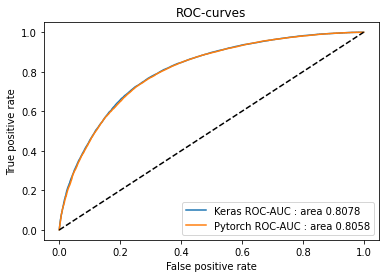

In [228]:
plt.plot(fpr_keras, tpr_keras, label=f'Keras ROC-AUC : area {auc_keras:.4f}')
plt.plot(fpr_pytorch, tpr_pytorch, label=f'Pytorch ROC-AUC : area {auc_pytorch:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-curves')

plt.legend()
plt.savefig('roc-auc.png')
plt.show()

### 2. Metrics

Keras Implementation

In [229]:
print(f'Testing Accuracy {accuracy_keras:.3f}')
print(f'F1 score: {f1_keras:.3f}')
print(f'ROC-AUC: {auc_keras:.4f}')

Testing Accuracy 0.737
F1 score: 0.737
ROC-AUC: 0.8078


Pytorch Implementation


In [230]:
print(f'Testing Accuracy {acc_pytorch:.3f}')
print(f'F1 score: {f1_pytorch:.3f}')
print(f'ROC-AUC: {auc_pytorch:.4f}')

Testing Accuracy 0.736
F1 score: 0.738
ROC-AUC: 0.8058
